In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import Imputer
import random
from fancyimpute import KNN,mice,MICE
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import TransformerMixin, BaseEstimator

#alter imputation method
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        #if self.strategy in ['mean','median']:
        #    if not all(X.dtypes == np.number):
        #        raise ValueError('dtypes mismatch np.number dtype is \
         #                        required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## 1. Import Data

### filt out columns that contain more than 80% missing values
### df shape is 35427*58; each row is a unique person

In [11]:
df = pd.read_csv("MEPS_select_add_feature_filter0.8.csv")

In [12]:
df.shape

(35427, 56)

In [13]:
#df.DUPERSID.nunique() == df.shape[0]

In [14]:
#check NaN COUNTS
df.isnull().sum().describe()

count       56.000000
mean      7166.821429
std       8438.281225
min          0.000000
25%        213.000000
50%       2076.500000
75%      14047.000000
max      27469.000000
dtype: float64

In [15]:
df=df.iloc[:,2:]

In [16]:
# check column type
print(df.dtypes)
df.columns

MARRY31X    float64
FAMSZEYR      int64
LANGSPK     float64
VETSP15X      int64
INSCOV15      int64
ACTDTY53    float64
AGE53X      float64
DFHEAR42    float64
HEARAD42    float64
DFDRSB42    float64
DFCOG42     float64
EDUYRDG     float64
EMPST53     float64
RACETHX       int64
POVLEV15    float64
OFREMP31    float64
OFREMP42    float64
OFREMP53    float64
INSAT53X    float64
REGION15    float64
FOODST15    float64
HOUR31      float64
DFWLKC42    float64
DFERND42    float64
ERTOT15       int64
OBTOTV15      int64
OBOTHV15      int64
OPTOTV15      int64
RXTOT15       int64
BMINDX53    float64
HIBPAGED    float64
AGELAST       int64
ADPAIN42    float64
ADCAPE42    float64
EDRECODE    float64
ADNRGY42    float64
RTHLTH53    float64
RTHLTH42    float64
RTHLTH31    float64
MNHLTH42    float64
MNHLTH31    float64
MNHLTH53    float64
TYPEPE42    float64
BPCHEK53    float64
CHOLCK53    float64
EXRCIS53    float64
ASPRIN53    float64
ADSMOK42    float64
CHECK53     float64
ADILCR42    float64


Index(['MARRY31X', 'FAMSZEYR', 'LANGSPK', 'VETSP15X', 'INSCOV15', 'ACTDTY53',
       'AGE53X', 'DFHEAR42', 'HEARAD42', 'DFDRSB42', 'DFCOG42', 'EDUYRDG',
       'EMPST53', 'RACETHX', 'POVLEV15', 'OFREMP31', 'OFREMP42', 'OFREMP53',
       'INSAT53X', 'REGION15', 'FOODST15', 'HOUR31', 'DFWLKC42', 'DFERND42',
       'ERTOT15', 'OBTOTV15', 'OBOTHV15', 'OPTOTV15', 'RXTOT15', 'BMINDX53',
       'HIBPAGED', 'AGELAST', 'ADPAIN42', 'ADCAPE42', 'EDRECODE', 'ADNRGY42',
       'RTHLTH53', 'RTHLTH42', 'RTHLTH31', 'MNHLTH42', 'MNHLTH31', 'MNHLTH53',
       'TYPEPE42', 'BPCHEK53', 'CHOLCK53', 'EXRCIS53', 'ASPRIN53', 'ADSMOK42',
       'CHECK53', 'ADILCR42', 'ADNERV42', 'ADINTR42', 'ADINSA42', 'TOTEXP15'],
      dtype='object')

In [17]:
df.head() # IMPATIENT / EM/ OUTPATIENT EXP

,MARRY31X,FAMSZEYR,LANGSPK,VETSP15X,INSCOV15,ACTDTY53,AGE53X,DFHEAR42,HEARAD42,DFDRSB42,...,CHOLCK53,EXRCIS53,ASPRIN53,ADSMOK42,CHECK53,ADILCR42,ADNERV42,ADINTR42,ADINSA42,TOTEXP15
0,5.0,5,NaN,0,2,2.0,53.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,46612
1,3.0,5,NaN,0,2,2.0,56.0,2.0,2.0,2.0,...,NaN,1.0,2.0,2.0,1.0,1.0,3.0,3.0,1.0,9207
2,5.0,5,NaN,0,1,2.0,30.0,2.0,2.0,2.0,...,6.0,2.0,2.0,NaN,2.0,2.0,1.0,0.0,3.0,0
3,5.0,5,NaN,0,2,2.0,23.0,2.0,2.0,2.0,...,6.0,2.0,2.0,2.0,4.0,1.0,2.0,0.0,2.0,808
4,6.0,5,NaN,0,2,3.0,3.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2721


## 2. EDA

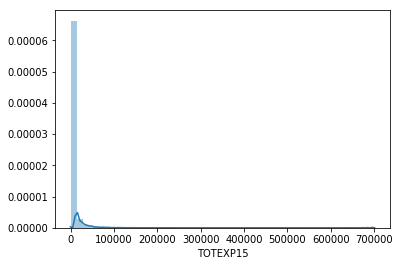

In [18]:
sns.distplot(df.TOTEXP15)

In [37]:
df.TOTEXP15.describe()

count     35427.000000
mean       4171.132639
std       14037.579996
min           0.000000
25%          92.000000
50%         620.000000
75%        2850.000000
max      700771.000000
Name: TOTEXP15, dtype: float64

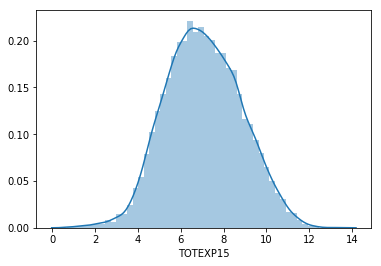

In [38]:
# reduce effect of long tail/outlier
df_log = np.log(df[(df.TOTEXP15 > 1)].TOTEXP15)
sns.distplot(df_log)

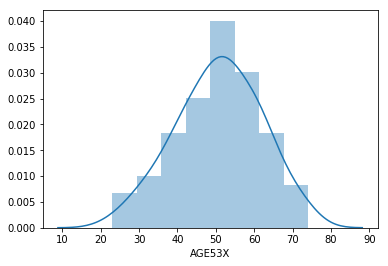

In [39]:
#age
sns.distplot(df.dropna().AGE53X)

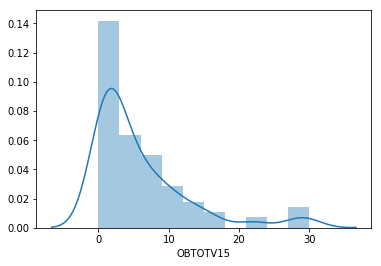

In [40]:
#income
sns.distplot(df.dropna().OBTOTV15 )

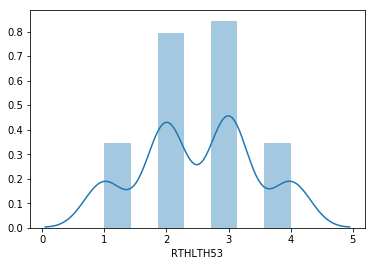

In [41]:
# perceived health status #left is perfect
sns.distplot(df.dropna().RTHLTH53)

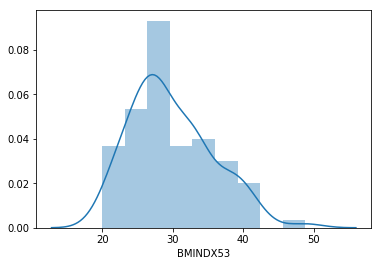

In [42]:
sns.distplot(df.dropna().BMINDX53)

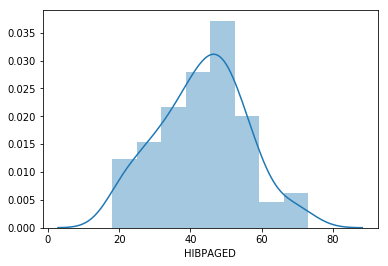

In [43]:
#AGE OF HIGH BLOOD PRESSURE DIAGNOSIS
sns.distplot(df.dropna().HIBPAGED)

In [58]:
num = ["AGE53X","POVLEV15",
       "FAMINC15","OBTOTV15","OBOTHV15","OPTOTV15","RXTOT15","ERTOT15",
       "BMINDX53", "AGELAST","ADPAIN42","ADCAPE42","EDRECODE","ADNRGY","RTHLTH53"
       ,"MNHLTH42","MNHLTH31","MNHLTH53","HOUR31","HIBPAGED","VETSP15X",
       "TOTEXP15"]
df_num = df.filter(items = num)
tot_list = list(df)
cat = [x for x in tot_list if x not in num]
df_cat = df.filter(items = cat)
#df_eda = df_cat.append(df.TOTEXP15)

In [59]:
df_cat["TOTEXP15"] = df.TOTEXP15
#df_cat = df_cat.fillna(-1)
df_cat = df_cat.dropna()

0


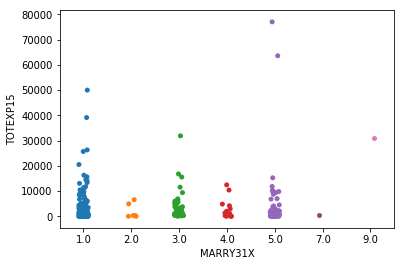

1


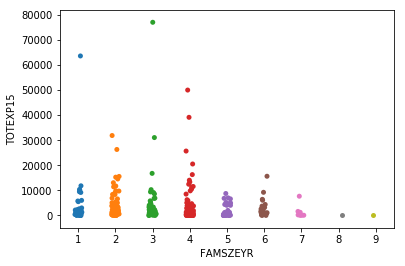

2


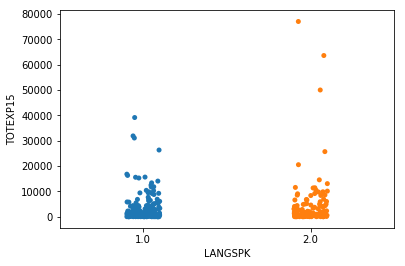

3


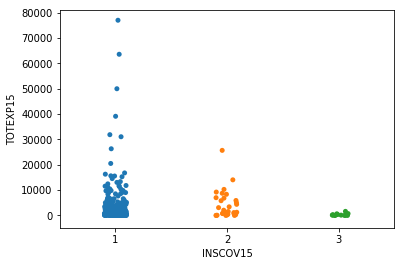

4


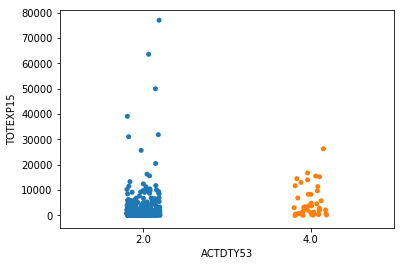

5


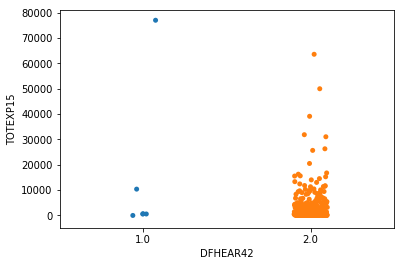

6


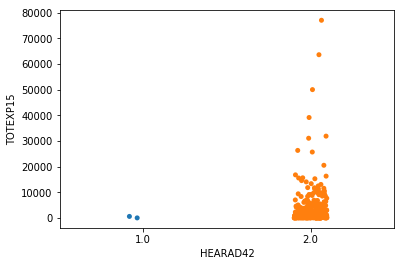

7


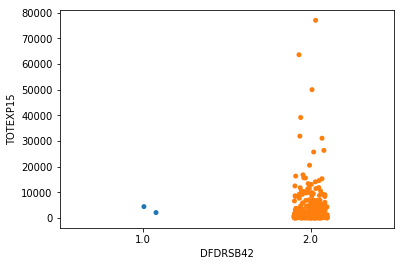

8


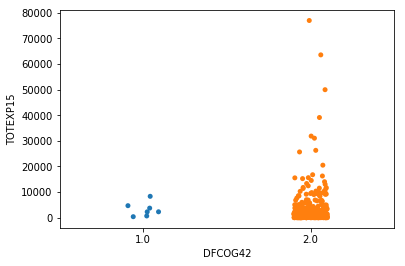

9


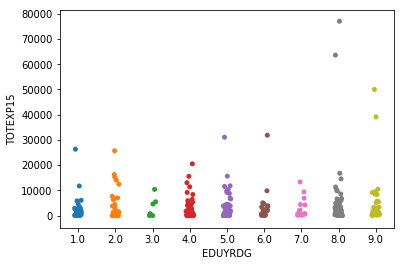

10


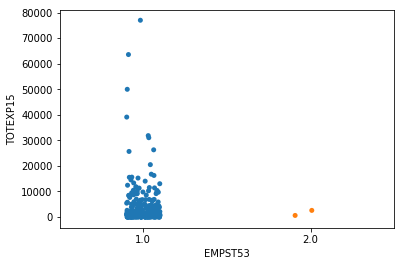

11


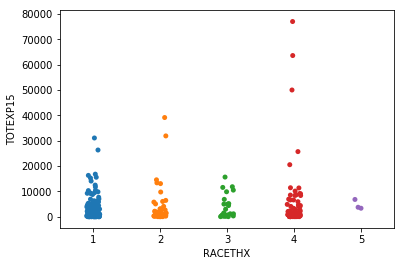

12


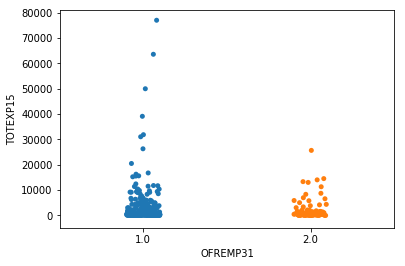

13


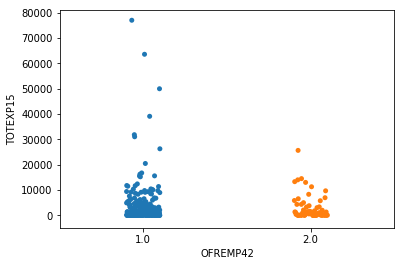

14


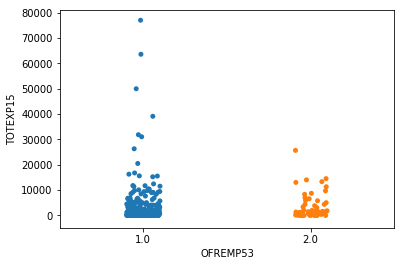

15


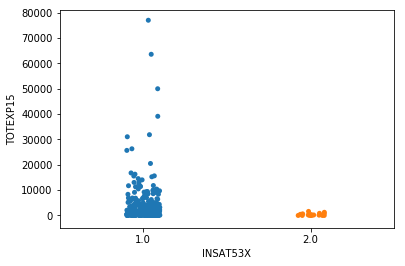

16


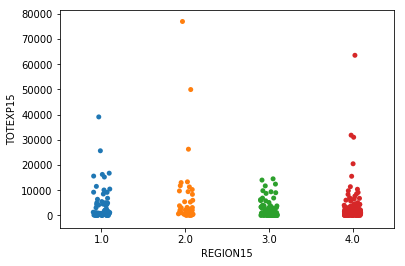

17


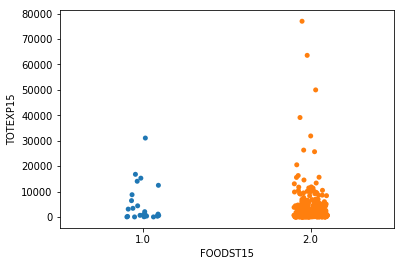

18


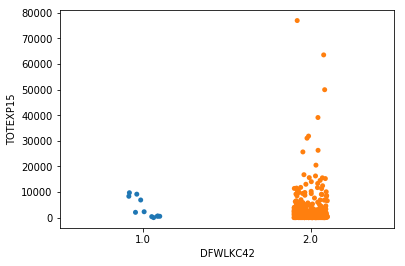

19


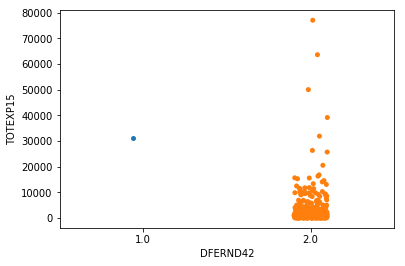

20


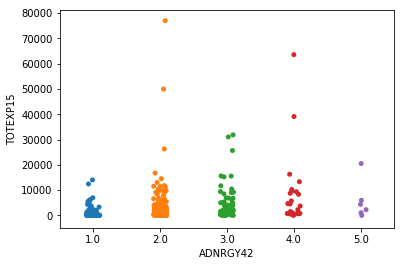

21


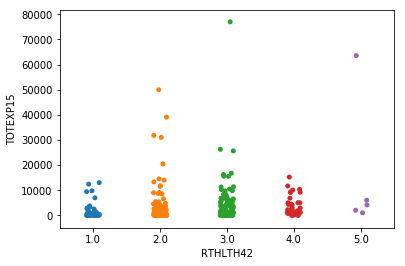

22


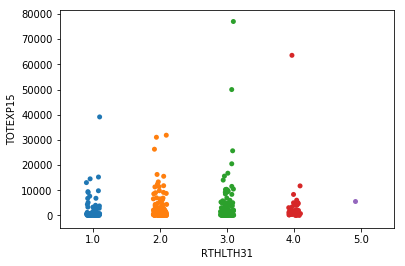

23


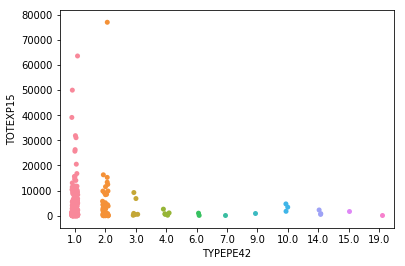

24


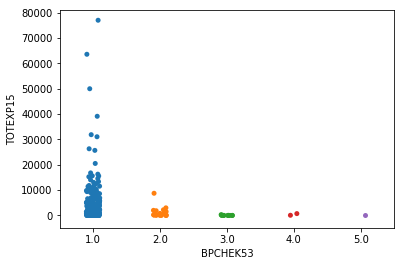

25


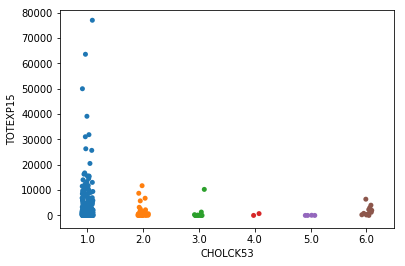

26


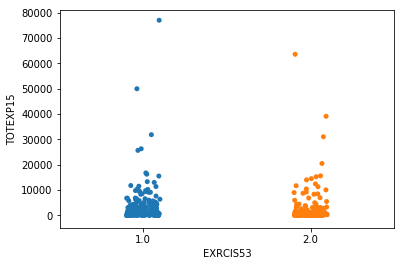

27


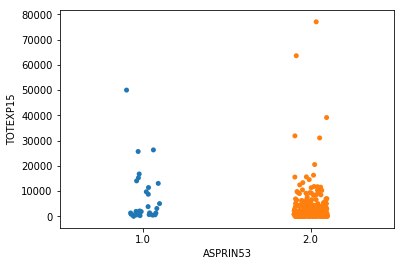

28


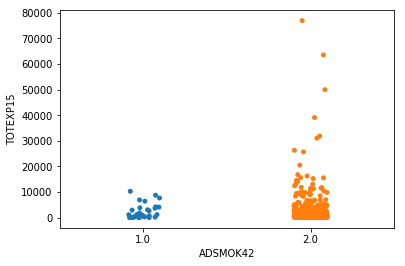

29


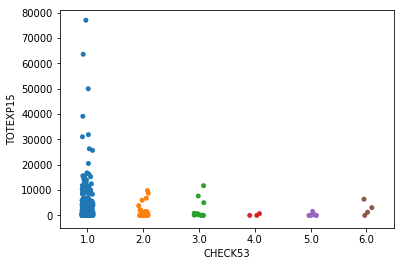

30


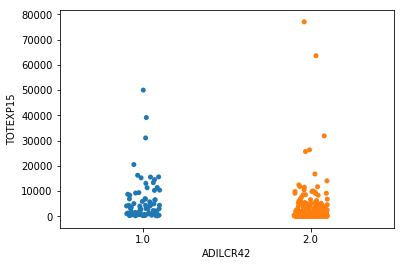

31


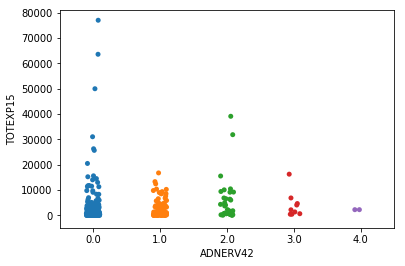

32


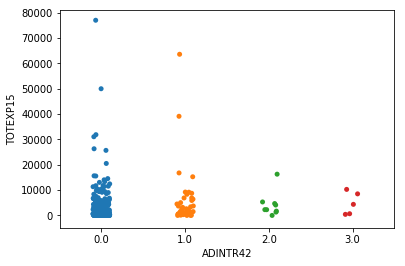

33


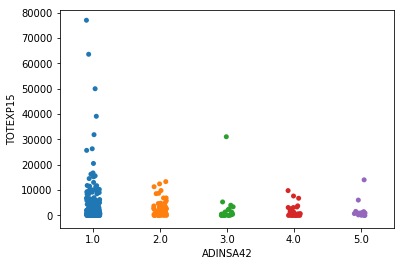

In [60]:
for i, cols in enumerate(df_cat.columns[:-1]):
    print(i)
    plt.figure(i)
    sns.stripplot(x=cols, y="TOTEXP15", data=df_cat,jitter = True)
    plt.show()

## 3. preprocess data
#### for categorical variables:  fill mean, mode, new leve; then one-hot
#### for numerical (and ordinal) tried mean; KNN; MICE; euclidean distance

In [24]:
num_ord = ["AGE53X","TTLP15X","POVLEV15",
       "FAMINC15","OBTOTV15","OBOTHV15","OPTOTV15","RXTOT15","ERTOT15",### add below here
       "BMINDX53", "AGELAST","ADPAIN42","ADCAPE42","EDRECODE","ADNRGY","RTHLTH53",
        "MNHLTH42","MNHLTH31","MNHLTH53","HOUR31","HIBPAGED","VETSP15X","FAMSZERYR","ACTDTY53",
        "ADNRGY42","RTHLTH42", "BPCHEK53", "CHOLCK53", "CHECK53","ADNERV42","ADINTR42","ADINSA42",
        "HOUR31" , "ADCAPE42","HIBPAGED", "POVLEV15","ADCAPE42","HIBPAGED",
           
       "TOTEXP15"]


tot_list = list(df)
cat = [x for x in tot_list if x not in num_ord]
df_num_ord = df.filter(items = num_ord)
df_cat = df.filter(items = cat)

In [25]:
tot_list = list(df)
cat = [x for x in tot_list if x not in num_ord]
df_num_ord = df.filter(items = num_ord)
df_cat = df.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = CustomImputer(strategy='mode').fit_transform(df_cat)
#################
#for numerical
df_num_ord=pd.DataFrame(data=KNN(k=3).complete(df_num_ord), columns=df_num_ord.columns, index=df_num_ord.index)
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  


encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)

imputing variables...
Imputing row 1/35427 with 2 missing, elapsed time: 616.909
Imputing row 101/35427 with 20 missing, elapsed time: 617.693
Imputing row 201/35427 with 13 missing, elapsed time: 618.151
Imputing row 301/35427 with 18 missing, elapsed time: 618.613
Imputing row 401/35427 with 2 missing, elapsed time: 619.364
Imputing row 501/35427 with 3 missing, elapsed time: 619.777
Imputing row 601/35427 with 3 missing, elapsed time: 620.302
Imputing row 701/35427 with 12 missing, elapsed time: 620.674
Imputing row 801/35427 with 17 missing, elapsed time: 621.149
Imputing row 901/35427 with 3 missing, elapsed time: 621.577
Imputing row 1001/35427 with 3 missing, elapsed time: 622.051
Imputing row 1101/35427 with 17 missing, elapsed time: 622.547
Imputing row 1201/35427 with 1 missing, elapsed time: 622.912
Imputing row 1301/35427 with 17 missing, elapsed time: 623.259
Imputing row 1401/35427 with 0 missing, elapsed time: 623.671
Imputing row 1501/35427 with 5 missing, elapsed time:

Imputing row 13101/35427 with 18 missing, elapsed time: 674.098
Imputing row 13201/35427 with 18 missing, elapsed time: 674.886
Imputing row 13301/35427 with 2 missing, elapsed time: 675.616
Imputing row 13401/35427 with 2 missing, elapsed time: 676.059
Imputing row 13501/35427 with 17 missing, elapsed time: 676.438
Imputing row 13601/35427 with 11 missing, elapsed time: 676.802
Imputing row 13701/35427 with 18 missing, elapsed time: 677.236
Imputing row 13801/35427 with 3 missing, elapsed time: 677.547
Imputing row 13901/35427 with 17 missing, elapsed time: 677.853
Imputing row 14001/35427 with 13 missing, elapsed time: 678.231
Imputing row 14101/35427 with 16 missing, elapsed time: 678.648
Imputing row 14201/35427 with 5 missing, elapsed time: 679.112
Imputing row 14301/35427 with 21 missing, elapsed time: 679.598
Imputing row 14401/35427 with 17 missing, elapsed time: 680.159
Imputing row 14501/35427 with 3 missing, elapsed time: 680.708
Imputing row 14601/35427 with 2 missing, elap

Imputing row 26101/35427 with 5 missing, elapsed time: 723.628
Imputing row 26201/35427 with 3 missing, elapsed time: 723.972
Imputing row 26301/35427 with 3 missing, elapsed time: 724.334
Imputing row 26401/35427 with 18 missing, elapsed time: 724.682
Imputing row 26501/35427 with 17 missing, elapsed time: 725.112
Imputing row 26601/35427 with 3 missing, elapsed time: 725.563
Imputing row 26701/35427 with 2 missing, elapsed time: 725.978
Imputing row 26801/35427 with 17 missing, elapsed time: 726.477
Imputing row 26901/35427 with 0 missing, elapsed time: 726.977
Imputing row 27001/35427 with 11 missing, elapsed time: 727.351
Imputing row 27101/35427 with 18 missing, elapsed time: 727.706
Imputing row 27201/35427 with 0 missing, elapsed time: 728.076
Imputing row 27301/35427 with 3 missing, elapsed time: 728.508
Imputing row 27401/35427 with 18 missing, elapsed time: 728.889
Imputing row 27501/35427 with 17 missing, elapsed time: 729.347
Imputing row 27601/35427 with 3 missing, elapsed

## 4.fitting models
### lm model/ ridge/ lasso as baseline

In [32]:
df_xgb_log = df_preprocessed.loc[df_preprocessed['TOTEXP15'] > 0]
x = df_xgb_log.iloc[:, :-1]
y = np.log(df_xgb_log["TOTEXP15"])
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [35]:
modelCV = RidgeCV(alphas = [10,1,0.1, 0.01, 0.001], store_cv_values = True)
#reg = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=-1)
reg=modelCV.fit(X_train,y_train)
print("cv_alpha is:",modelCV.alpha_)
print(" test r^2",modelCV.score(X_test,y_test) )
mae = np.sqrt(mean_absolute_error(y_train, reg.predict(X_train)))
print("training mae", mae)
mae = np.sqrt(mean_absolute_error(y_test, reg.predict(X_test)))
print("test mae", mae)


cv_lpha is: 1.0
 test r^2 0.553801635796326
training mae 0.948737682012944
test mae 0.9424399113170724


In [38]:
modelCV = LassoCV(alphas = [10,1,0.1])
#reg = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=-1)
reg=modelCV.fit(X_train,y_train)
print("cv_alpha is:",modelCV.alpha_)
print(" test r^2",modelCV.score(X_test,y_test) )
mae = np.sqrt(mean_absolute_error(y_train, reg.predict(X_train)))
print("training mae", mae)
mae = np.sqrt(mean_absolute_error(y_test, reg.predict(X_test)))
print("test mae", mae)

cv_lpha is: 0.1
 test r^2 0.5305831574359736
training mae 0.9699735599512479
test mae 0.9604121217464036


### decision tree

In [272]:
parameters = {'max_depth':[3,5]}

reg = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=-1)
reg = reg.fit(X_train,y_train)
print("cv_depth is:",reg.best_params_)
print(" test r^2",modelCV.score(X_test,y_test) )
mae = (mean_absolute_error(y_train, reg.predict(X_train)))
print("training mae", mae)
mae = np.sqrt(mean_absolute_error(y_test, reg.predict(X_test)))
print("test mae", rmse)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


cv_depth is: {'max_depth': 5}
 test r^2 0.5304077637345959
training mae 0.8378339335602727
test mae 1.2058455537899473


### random forest

In [246]:
# mode/ knn
param_grid = {
    'bootstrap': [True],
    'max_depth': [8,10],
    'max_features': [5, 7],
    'min_samples_leaf': [2,3],
    'min_samples_split': [8, 10],
    'n_estimators': [50,100 ]}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose=1)
reg = grid_search.fit(X_train, y_train)


print (reg.best_score_, reg.best_params_)


mae = np.sqrt(mean_absolute_error(y_train, reg.predict(X_train)))
print("training mae",mae)

mae = np.sqrt(mean_absolute_error(y_test, reg.predict(X_test)))
print("test mae",mae)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.557309611445862 {'bootstrap': True, 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
training mae 0.9203253499947148
test mae 0.944196296236332


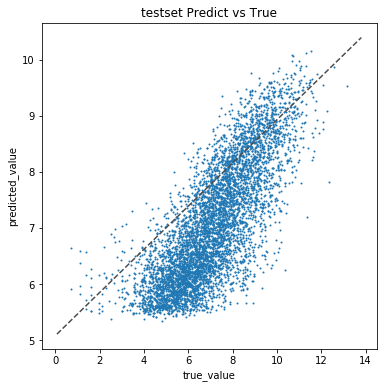

In [247]:
pred = reg.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred,s=1)
plt.title("testset Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.show()

### XGB

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.6min finished


r^2 0.47813990764918385
0.28538278687595814 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
train mae: 3196.834925405535
test mae: 3265.908452445425


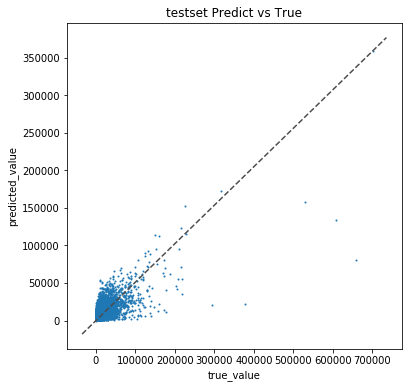

In [188]:
# xgb_base/ no transform of y # mode/knn

# XGB
df_xgb_base = df_preprocessed
x = df_xgb_base.iloc[:, :-1]
y = df_xgb_base["TOTEXP15"]
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [25,50,100],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)


print("r^2",xgb_m.score(X=X_train,y=y_train) )
print (xgb_m.best_score_, xgb_m.best_params_)
mae_train = mean_absolute_error(y_train, xgb_m.predict(X_train))
print("train mae:" , mae_train)
mae_test = mean_absolute_error(y_test, xgb_m.predict(X_test))
print("test mae:" , mae_test)
pred = xgb_m.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred,s=0.5)
plt.title("testset Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.show()

In [91]:
# XGB with log_transform of y/ mode/ knn
df_xgb_log = df_preprocessed.loc[df_preprocessed['TOTEXP15'] > 0]
x = df_xgb_log.iloc[:, :-1]
y = np.log(df_xgb_log["TOTEXP15"])
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [25,50,100],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)

print("r^2",xgb_m.score(X=X_train,y=y_train) )
print (xgb_m.best_score_, xgb_m.best_params_)
mae_train = mean_absolute_error(y_train, xgb_m.predict(X_train))
print("train mae:" , mae_train)
mae_test = mean_absolute_error(y_test, xgb_m.predict(X_test))
print("test mae:" , mae_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


r^2 0.7015698833516426
0.6780874080222042 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
train mae: 0.7265849051728807
test mae: 0.7363254987859212


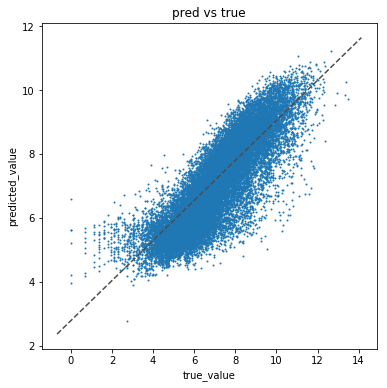

In [120]:
pred = xgb_m.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred,s=1)
plt.title("testset Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.show()

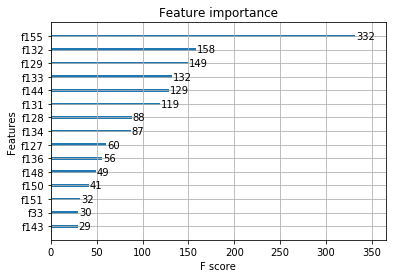

In [154]:
#PLOT IMPORTANCE
model  = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model,max_num_features=15)
plt.show()

In [157]:
f=[]
for x in [155,132,129,133,144,131,128,134,127,136,148,150,151,143]:
    f.append(df_preprocessed.columns[x])
    print(df_preprocessed.columns[x])

ADINSA42
RXTOT15
OBTOTV15
ERTOT15
HIBPAGED
OPTOTV15
POVLEV15
BMINDX53
AGE53X
ADPAIN42
ADNRGY42
BPCHEK53
CHOLCK53
HOUR31


##### ADINSA :do not need health insurance?                              
##### RXTOT: total prescribed medicine
##### ERTOT: count of emergency room visit
##### HIBPAGED: high blood pressure
##### OBTOTV: office based visit; optotv: out patient visit
##### BMI
##### AGE
##### family income
##### pain interfered with normal work
##### feel energetic?
#####  BPCHEK;CHOLCK: how long since last blood pressure;cholesterol check？
##### HOUR31: work hours

0


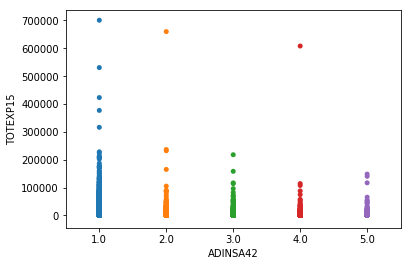

1


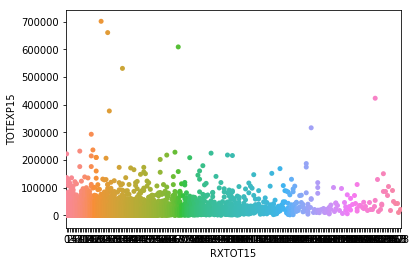

2


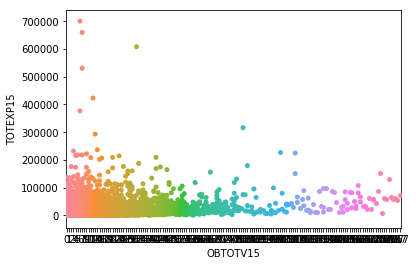

3


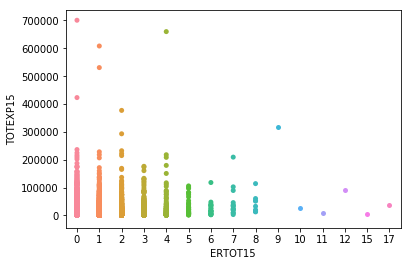

4


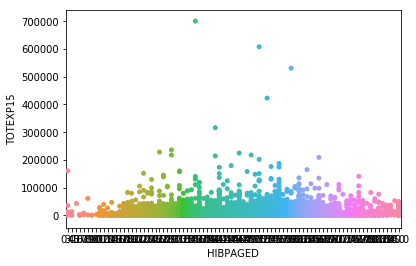

5


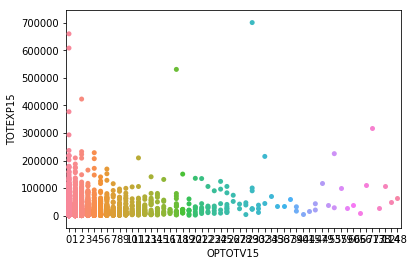

6


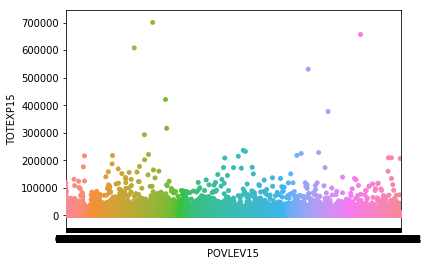

7


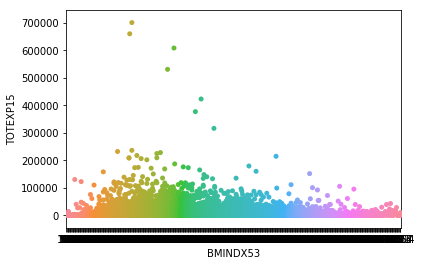

8


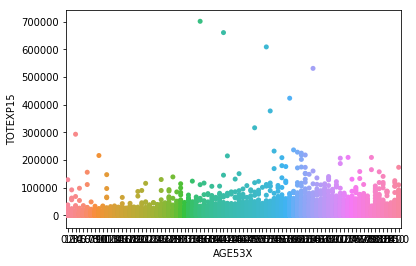

9


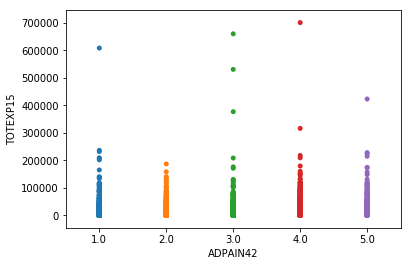

10


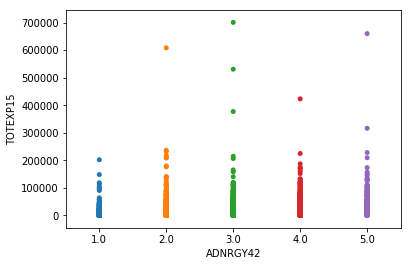

11


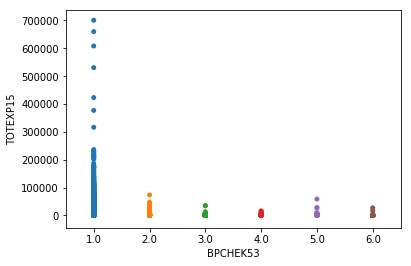

12


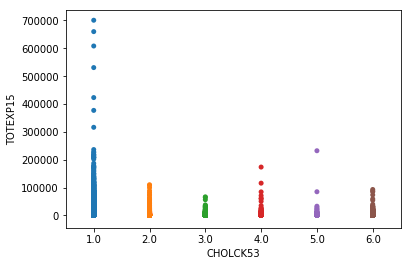

13


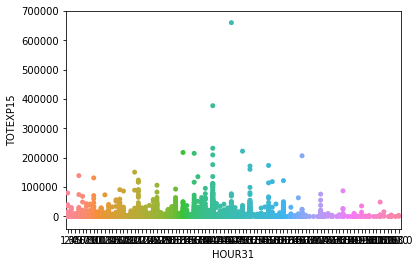

In [158]:
for i, cols in enumerate(f):
    print(i)
    plt.figure(i)
    sns.stripplot(x=str(cols), y="TOTEXP15", data=df)
    plt.show()

In [ ]:
#疾病vs花费

In [252]:
# try mean imputing with same xgb/log(y)


df = pd.read_csv("MEPS_select_add_feature_filter0.8.csv")
df=df.iloc[:,2:]
tot_list = list(df)
cat = [x for x in tot_list if x not in num_ord]
df_num_ord = df.filter(items = num_ord)
df_cat = df.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = CustomImputer(strategy='mean').fit_transform(df_cat)
#################
#for numerical
df_num_ord=pd.DataFrame(data=KNN(k=3).complete(df_num_ord), columns=df_num_ord.columns, index=df_num_ord.index)
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  


encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)

# XGB with log_transform of y
df_xgb_log = df_preprocessed.loc[df_preprocessed['TOTEXP15'] > 0]
x = df_xgb_log.iloc[:, :-1]
y = np.log(df_xgb_log["TOTEXP15"])
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [50,100],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)

print("r^2",xgb_m.score(X=X_train,y=y_train) )
print (xgb_m.best_score_, xgb_m.best_params_)
mae_train = mean_absolute_error(y_train, xgb_m.predict(X_train))
print("train mae:" , mae_train)
mae_test = mean_absolute_error(y_test, xgb_m.predict(X_test))
print("test mae:" , mae_test)

imputing variables...
Imputing row 1/35427 with 2 missing, elapsed time: 715.714
Imputing row 101/35427 with 21 missing, elapsed time: 719.451
Imputing row 201/35427 with 13 missing, elapsed time: 720.527
Imputing row 301/35427 with 18 missing, elapsed time: 721.207
Imputing row 401/35427 with 2 missing, elapsed time: 721.771
Imputing row 501/35427 with 3 missing, elapsed time: 722.411
Imputing row 601/35427 with 3 missing, elapsed time: 722.846
Imputing row 701/35427 with 13 missing, elapsed time: 723.549
Imputing row 801/35427 with 17 missing, elapsed time: 724.056
Imputing row 901/35427 with 3 missing, elapsed time: 724.554
Imputing row 1001/35427 with 3 missing, elapsed time: 724.928
Imputing row 1101/35427 with 17 missing, elapsed time: 725.390
Imputing row 1201/35427 with 1 missing, elapsed time: 725.806
Imputing row 1301/35427 with 17 missing, elapsed time: 726.214
Imputing row 1401/35427 with 0 missing, elapsed time: 726.745
Imputing row 1501/35427 with 5 missing, elapsed time:

Imputing row 13101/35427 with 18 missing, elapsed time: 775.205
Imputing row 13201/35427 with 18 missing, elapsed time: 775.533
Imputing row 13301/35427 with 2 missing, elapsed time: 775.969
Imputing row 13401/35427 with 2 missing, elapsed time: 776.270
Imputing row 13501/35427 with 17 missing, elapsed time: 776.676
Imputing row 13601/35427 with 11 missing, elapsed time: 777.227
Imputing row 13701/35427 with 18 missing, elapsed time: 777.870
Imputing row 13801/35427 with 3 missing, elapsed time: 778.332
Imputing row 13901/35427 with 17 missing, elapsed time: 778.736
Imputing row 14001/35427 with 13 missing, elapsed time: 779.236
Imputing row 14101/35427 with 16 missing, elapsed time: 779.682
Imputing row 14201/35427 with 5 missing, elapsed time: 780.264
Imputing row 14301/35427 with 22 missing, elapsed time: 780.676
Imputing row 14401/35427 with 17 missing, elapsed time: 781.194
Imputing row 14501/35427 with 3 missing, elapsed time: 781.635
Imputing row 14601/35427 with 2 missing, elap

Imputing row 26101/35427 with 6 missing, elapsed time: 834.815
Imputing row 26201/35427 with 4 missing, elapsed time: 835.346
Imputing row 26301/35427 with 4 missing, elapsed time: 835.779
Imputing row 26401/35427 with 19 missing, elapsed time: 836.215
Imputing row 26501/35427 with 18 missing, elapsed time: 836.636
Imputing row 26601/35427 with 4 missing, elapsed time: 837.083
Imputing row 26701/35427 with 3 missing, elapsed time: 837.512
Imputing row 26801/35427 with 18 missing, elapsed time: 837.907
Imputing row 26901/35427 with 1 missing, elapsed time: 838.360
Imputing row 27001/35427 with 12 missing, elapsed time: 838.831
Imputing row 27101/35427 with 19 missing, elapsed time: 839.309
Imputing row 27201/35427 with 1 missing, elapsed time: 839.720
Imputing row 27301/35427 with 4 missing, elapsed time: 840.207
Imputing row 27401/35427 with 19 missing, elapsed time: 840.676
Imputing row 27501/35427 with 18 missing, elapsed time: 841.257
Imputing row 27601/35427 with 4 missing, elapsed

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


r^2 0.747983005017252
0.7005613923459892 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
train mae: 0.6699241329163879
test mae: 0.7095999808497039


In [253]:
#fill/ knn;

df = pd.read_csv("MEPS_select_add_feature_filter0.8.csv")
df=df.iloc[:,2:]
tot_list = list(df)
cat = [x for x in tot_list if x not in num_ord]
df_num_ord = df.filter(items = num_ord)
df_cat = df.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = CustomImputer(strategy='fill', filler=100).fit_transform(df_cat)
#################
#for numerical
df_num_ord=pd.DataFrame(data=KNN(k=3).complete(df_num_ord), columns=df_num_ord.columns, index=df_num_ord.index)
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  


encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)

# XGB with log_transform of y
df_xgb_log = df_preprocessed.loc[df_preprocessed['TOTEXP15'] > 0]
x = df_xgb_log.iloc[:, :-1]
y = np.log(df_xgb_log["TOTEXP15"])
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [25,50,100],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)

print("r^2",xgb_m.score(X=X_train,y=y_train) )
print (xgb_m.best_score_, xgb_m.best_params_)
mae_train = mean_absolute_error(y_train, xgb_m.predict(X_train))
print("train mae:" , mae_train)
mae_test = mean_absolute_error(y_test, xgb_m.predict(X_test))
print("test mae:" , mae_test)

imputing variables...
Imputing row 1/35427 with 2 missing, elapsed time: 805.878
Imputing row 101/35427 with 21 missing, elapsed time: 806.300
Imputing row 201/35427 with 13 missing, elapsed time: 806.645
Imputing row 301/35427 with 18 missing, elapsed time: 807.058
Imputing row 401/35427 with 2 missing, elapsed time: 807.485
Imputing row 501/35427 with 3 missing, elapsed time: 807.875
Imputing row 601/35427 with 3 missing, elapsed time: 808.210
Imputing row 701/35427 with 13 missing, elapsed time: 808.578
Imputing row 801/35427 with 17 missing, elapsed time: 808.911
Imputing row 901/35427 with 3 missing, elapsed time: 809.344
Imputing row 1001/35427 with 3 missing, elapsed time: 809.694
Imputing row 1101/35427 with 17 missing, elapsed time: 810.045
Imputing row 1201/35427 with 1 missing, elapsed time: 810.395
Imputing row 1301/35427 with 17 missing, elapsed time: 810.775
Imputing row 1401/35427 with 0 missing, elapsed time: 811.179
Imputing row 1501/35427 with 5 missing, elapsed time:

Imputing row 13101/35427 with 18 missing, elapsed time: 861.544
Imputing row 13201/35427 with 18 missing, elapsed time: 861.873
Imputing row 13301/35427 with 2 missing, elapsed time: 862.486
Imputing row 13401/35427 with 2 missing, elapsed time: 862.918
Imputing row 13501/35427 with 17 missing, elapsed time: 863.759
Imputing row 13601/35427 with 11 missing, elapsed time: 864.393
Imputing row 13701/35427 with 18 missing, elapsed time: 864.890
Imputing row 13801/35427 with 3 missing, elapsed time: 865.435
Imputing row 13901/35427 with 17 missing, elapsed time: 865.827
Imputing row 14001/35427 with 13 missing, elapsed time: 866.358
Imputing row 14101/35427 with 16 missing, elapsed time: 866.884
Imputing row 14201/35427 with 5 missing, elapsed time: 867.363
Imputing row 14301/35427 with 22 missing, elapsed time: 867.828
Imputing row 14401/35427 with 17 missing, elapsed time: 868.562
Imputing row 14501/35427 with 3 missing, elapsed time: 869.009
Imputing row 14601/35427 with 2 missing, elap

Imputing row 26101/35427 with 6 missing, elapsed time: 926.502
Imputing row 26201/35427 with 4 missing, elapsed time: 926.973
Imputing row 26301/35427 with 4 missing, elapsed time: 927.378
Imputing row 26401/35427 with 19 missing, elapsed time: 927.843
Imputing row 26501/35427 with 18 missing, elapsed time: 928.390
Imputing row 26601/35427 with 4 missing, elapsed time: 928.947
Imputing row 26701/35427 with 3 missing, elapsed time: 929.489
Imputing row 26801/35427 with 18 missing, elapsed time: 930.037
Imputing row 26901/35427 with 1 missing, elapsed time: 930.588
Imputing row 27001/35427 with 12 missing, elapsed time: 931.193
Imputing row 27101/35427 with 19 missing, elapsed time: 931.716
Imputing row 27201/35427 with 1 missing, elapsed time: 932.184
Imputing row 27301/35427 with 4 missing, elapsed time: 932.631
Imputing row 27401/35427 with 19 missing, elapsed time: 933.100
Imputing row 27501/35427 with 18 missing, elapsed time: 933.526
Imputing row 27601/35427 with 4 missing, elapsed

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


r^2 0.7682331449366233
0.701364228400286 {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
train mae: 0.6423719196457613
test mae: 0.7061827441987077


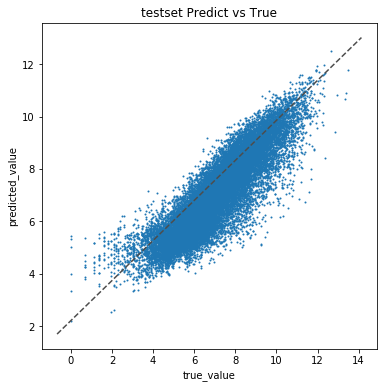

In [255]:
pred = xgb_m.predict(X_test)
true = y_test
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(true, pred,s=1)
plt.title("testset Predict vs True")
plt.xlabel("true_value")
plt.ylabel("predicted_value")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.show()

In [238]:
# fill/ mice

df = pd.read_csv("MEPS_select_add_feature_filter0.8.csv")
df=df.iloc[:,2:]
tot_list = list(df)
cat = [x for x in tot_list if x not in num_ord]
df_num_ord = df.filter(items = num_ord)
df_cat = df.filter(items = cat)
#################
#for categorical 
print("imputing variables...")
df_cat = CustomImputer(strategy="mode").fit_transform(df_cat)
#################
#for numerical
df_num_ord=pd.DataFrame(data=MICE().complete(df_num_ord), columns=df_num_ord.columns, index=df_num_ord.index)
####  one hot categorical/ concatenate to num
print("encoding categorical variables...")
enc = OneHotEncoder()
enc.fit(df_cat)  


encoded=pd.DataFrame(enc.transform(df_cat).toarray())
df_preprocessed = pd.concat([encoded,df_num_ord],axis =1)

# XGB with log_transform of y
df_xgb_log = df_preprocessed.loc[df_preprocessed['TOTEXP15'] > 0]
x = df_xgb_log.iloc[:, :-1]
y = np.log(df_xgb_log["TOTEXP15"])
x = preprocessing.scale(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_m = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [25,35],
                    "learning_rate": [0.1,0.2,0.3]
                   }, verbose=1, n_jobs=-1, cv=3)

xgb_m = xgb_m.fit(X=X_train,y=y_train)

print("r^2",xgb_m.score(X=X_train,y=y_train) )
print (xgb_m.best_score_, xgb_m.best_params_)
mae_train = mean_absolute_error(y_train, xgb_m.predict(X_train))
print("train mae:" , mae_train)
mae_test = mean_absolute_error(y_test, xgb_m.predict(X_test))
print("test mae:" , mae_test)

imputing variables...
[MICE] Completing matrix with shape (35427, 36)
[MICE] Starting imputation round 1/110, elapsed time 0.037
[MICE] Starting imputation round 2/110, elapsed time 1.595
[MICE] Starting imputation round 3/110, elapsed time 3.576
[MICE] Starting imputation round 4/110, elapsed time 5.280
[MICE] Starting imputation round 5/110, elapsed time 7.099
[MICE] Starting imputation round 6/110, elapsed time 8.837
[MICE] Starting imputation round 7/110, elapsed time 10.991
[MICE] Starting imputation round 8/110, elapsed time 12.481
[MICE] Starting imputation round 9/110, elapsed time 13.771
[MICE] Starting imputation round 10/110, elapsed time 15.435
[MICE] Starting imputation round 11/110, elapsed time 16.663
[MICE] Starting imputation round 12/110, elapsed time 17.742
[MICE] Starting imputation round 13/110, elapsed time 18.809
[MICE] Starting imputation round 14/110, elapsed time 19.890
[MICE] Starting imputation round 15/110, elapsed time 21.235
[MICE] Starting imputation rou

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


r^2 0.7270045068922848
0.671861448990262 {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
train mae: 0.7003107327998565
test mae: 0.7503873728486286


### try simple NN


In [39]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_absolute_error', metrics =[metrics.mae])
    return model
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                3904      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=32)

Train on 22792 samples, validate on 5699 samples
Epoch 1/100
22792/22792 [==============================] - 2s 70us/step - loss: 1.9865 - mean_absolute_error: 1.9865 - val_loss: 1.3252 - val_mean_absolute_error: 1.3252
Epoch 2/100
22792/22792 [==============================] - 1s 52us/step - loss: 1.1815 - mean_absolute_error: 1.1815 - val_loss: 1.1449 - val_mean_absolute_error: 1.1449
Epoch 3/100
22792/22792 [==============================] - 1s 51us/step - loss: 1.0284 - mean_absolute_error: 1.0284 - val_loss: 1.0399 - val_mean_absolute_error: 1.0399
Epoch 4/100
22792/22792 [==============================] - 1s 48us/step - loss: 0.9641 - mean_absolute_error: 0.9641 - val_loss: 1.0089 - val_mean_absolute_error: 1.0089
Epoch 5/100
22792/22792 [==============================] - 1s 48us/step - loss: 0.9238 - mean_absolute_error: 0.9238 - val_loss: 0.8965 - val_mean_absolute_error: 0.8965
Epoch 6/100
22792/22792 [==============================] - 1s 49us/step - loss: 0.8915 - mean_absolut

Epoch 96/100
22792/22792 [==============================] - 1s 42us/step - loss: 0.7456 - mean_absolute_error: 0.7456 - val_loss: 0.7916 - val_mean_absolute_error: 0.7916
Epoch 97/100
22792/22792 [==============================] - 1s 45us/step - loss: 0.7486 - mean_absolute_error: 0.7486 - val_loss: 0.7598 - val_mean_absolute_error: 0.7598
Epoch 98/100
22792/22792 [==============================] - 1s 41us/step - loss: 0.7493 - mean_absolute_error: 0.7493 - val_loss: 0.7632 - val_mean_absolute_error: 0.7632
Epoch 99/100
22792/22792 [==============================] - 1s 40us/step - loss: 0.7487 - mean_absolute_error: 0.7487 - val_loss: 0.7823 - val_mean_absolute_error: 0.7823
Epoch 100/100
22792/22792 [==============================] - 1s 41us/step - loss: 0.7452 - mean_absolute_error: 0.7452 - val_loss: 0.7777 - val_mean_absolute_error: 0.7777


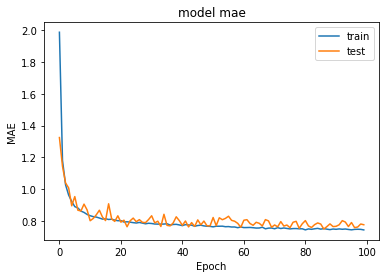

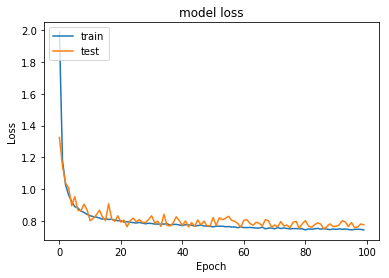

In [45]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5. summary
### best model : XGB ; 
### best imputation method : fill NAN as new level; fill numerical and ordinal using KNN


##  some important features : 
#### insurance: Do you agree to buy medical insurance? (ever had insurance/ employer offer insurance, etc)
#### visiting type : emergency room/ out patiend / office based visit
#### health status:  blood pressure/ cholesterol / feel energetic / pain interfered with normal work/ BMI
#### social economical status : family income / education level / working hours
#### others: total prescribed medicine